# Tech Challenge - Análise de Atrasos de Voos

**O problema** </br>
O transporte aéreo é uma parte vital da infraestrutura global, mas os 
atrasos de voos impactam milhões de passageiros todos os anos. Neste projeto, 
você utilizará o conjunto de dados público que contém informações detalhadas 
sobre voos nos EUA para desenvolver análises e modelos preditivos e/ou 
exploratórios aplicando técnicas de Machine Learning supervisionado e não 
supervisionado. 

**Objetivos do Projeto** </br>
Aplicar o conhecimento adquirido sobre modelagem supervisionada e não 
supervisionada e desenvolver um pipeline completo de ciência de dados, desde 
a exploração dos dados até a interpretação dos resultados. 

## Exploração dos dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar os dados dos arquivos CSV
flights_df = pd.read_csv('flights.csv')
airlines_df = pd.read_csv('airlines.csv')
airports_df = pd.read_csv('airports.csv')

C:\Users\Carol\AppData\Local\Temp\ipykernel_15756\2754484279.py:6: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_df = pd.read_csv('flights.csv')


Inicialmente, vamos observar apenas as primeiras linhas do nosso dataframe, selecionando apenas algumas colunas relevantes sobre atrasos. Com elas já conseguimos extrair algumas informações importantes.

In [2]:
# Copiando o dataframe principal e exibindo as primeiras linhas
df_convert_time_delay = flights_df.copy()[:10]

# Função para formatar horas no formato HHMM para HH:MM para melhor visualização
def format_heure(heure):
    if pd.isna(heure):
        return None
    heure_str = str(int(heure)).zfill(4)
    return f"{heure_str[:2]}:{heure_str[2:]}"

df_convert_time_delay['SCHEDULED_DEPARTURE'] = df_convert_time_delay['SCHEDULED_DEPARTURE'].apply(format_heure)
df_convert_time_delay['DEPARTURE_TIME'] = df_convert_time_delay['DEPARTURE_TIME'].apply(format_heure)
df_convert_time_delay['SCHEDULED_ARRIVAL'] = df_convert_time_delay['SCHEDULED_ARRIVAL'].apply(format_heure)
df_convert_time_delay['ARRIVAL_TIME'] = df_convert_time_delay['ARRIVAL_TIME'].apply(format_heure)

cols_relevant = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']

df_convert_time_delay[cols_relevant]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,00:05,23:54,-11.0,04:30,04:08,-22.0
1,00:10,00:02,-8.0,07:50,07:41,-9.0
2,00:20,00:18,-2.0,08:06,08:11,5.0
3,00:20,00:15,-5.0,08:05,07:56,-9.0
4,00:25,00:24,-1.0,03:20,02:59,-21.0
5,00:25,00:20,-5.0,06:02,06:10,8.0
6,00:25,00:19,-6.0,05:26,05:09,-17.0
7,00:30,00:44,14.0,08:03,07:53,-10.0
8,00:30,00:19,-11.0,05:45,05:32,-13.0
9,00:30,00:33,3.0,07:11,06:56,-15.0


### Explicação sobre Valores Negativos e Positivos em ARRIVAL_DELAY e DEPARTURE_DELAY

- **Valores positivos** (maiores que 0): Indicam atrasos. Para `ARRIVAL_DELAY`, o voo chegou atrasado; para `DEPARTURE_DELAY`, o voo partiu atrasado.
- **Valores negativos** (menores que 0): Indicam chegadas ou partidas adiantadas. Para `ARRIVAL_DELAY`, o voo chegou antes do horário programado; para `DEPARTURE_DELAY`, o voo partiu antes do horário programado.
- **Valor zero**: Chegada ou partida exatamente no horário programado.

### Análise e tratamento de valores nulos na coluna ARRIVAL_DELAY
Sendo o `ARRIVAL_DELAY` um dos principais dados para análise dos atrasos, vamos analisar seus valores nulos. Onde `ARRIVAL_DELAY` for nulo, vamos calcular ele através da diferença das colunas SCHEDULED_ARRIVAL e ARRIVAL_TIME, se presentes.

In [3]:
print(f"Quantidade de ARRIVAL_DELAY nulos: {flights_df['ARRIVAL_DELAY'].isnull().sum()}")

# Filtrar linhas onde ARRIVAL_DELAY é nulo e SCHEDULED_ARRIVAL e ARRIVAL_TIME não são nulos
df_filtered = flights_df[
    (flights_df['ARRIVAL_DELAY'].isnull()) &
    (flights_df['SCHEDULED_ARRIVAL'].notnull()) &
    (flights_df['ARRIVAL_TIME'].notnull())
].copy()

print(f"Linhas para calcular ARRIVAL_DELAY: {len(df_filtered)}")

def hhmm_to_minutes(hhmm):
    hhmm = int(hhmm)
    return (hhmm // 100) * 60 + (hhmm % 100)

df_filtered['SCHEDULED_MIN'] = df_filtered['SCHEDULED_ARRIVAL'].apply(hhmm_to_minutes)
df_filtered['ARRIVAL_MIN'] = df_filtered['ARRIVAL_TIME'].apply(hhmm_to_minutes)

# Diferença
df_filtered['ARRIVAL_DELAY'] = df_filtered['ARRIVAL_MIN'] - df_filtered['SCHEDULED_MIN']

# Ajuste para voos que cruzam a meia-noite
df_filtered.loc[
    df_filtered['ARRIVAL_DELAY'] < -720,
    'ARRIVAL_DELAY'
] += 1440

df_filtered[['FLIGHT_NUMBER', 'TAIL_NUMBER', 'ARRIVAL_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']].head(10)

Quantidade de ARRIVAL_DELAY nulos: 105071
Linhas para calcular ARRIVAL_DELAY: 12558


,FLIGHT_NUMBER,TAIL_NUMBER,ARRIVAL_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME
724,716,N944DL,282,1009,1451.0
1455,5237,N712SK,264,1041,1505.0
2218,1966,N685SW,139,1000,1219.0
2526,4555,N12552,182,1017,1319.0
2866,1081,N214WN,128,1135,1343.0
4225,1279,N541AA,338,1300,1838.0
4394,4506,N613SK,88,1225,1353.0
4574,6171,N17159,257,1218,1635.0
4636,4169,N11547,227,1243,1630.0
6422,399,N456UA,254,2105,119.0


In [4]:
# Aplicar os valores calculados de ARRIVAL_DELAY de df_filtered de volta ao flights_df
flights_df.update(df_filtered[['ARRIVAL_DELAY']])

# Verificar se os valores foram aplicados
verify_update_df = flights_df[(flights_df['FLIGHT_NUMBER'] == 716) & (flights_df['TAIL_NUMBER'] == 'N944DL')][['SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']]
print(verify_update_df)

     SCHEDULED_ARRIVAL  ARRIVAL_TIME  ARRIVAL_DELAY
724               1009        1451.0          282.0


### Análise de outras colunas com valores nulos

In [5]:
print("\nPercentual de valores nulos por coluna:")
null_percent = (flights_df.isnull().mean() * 100).round(2)
print(null_percent)


Percentual de valores nulos por coluna:
YEAR                    0.00
MONTH                   0.00
DAY                     0.00
DAY_OF_WEEK             0.00
AIRLINE                 0.00
FLIGHT_NUMBER           0.00
TAIL_NUMBER             0.25
ORIGIN_AIRPORT          0.00
DESTINATION_AIRPORT     0.00
SCHEDULED_DEPARTURE     0.00
DEPARTURE_TIME          1.48
DEPARTURE_DELAY         1.48
TAXI_OUT                1.53
WHEELS_OFF              1.53
SCHEDULED_TIME          0.00
ELAPSED_TIME            1.81
AIR_TIME                1.81
DISTANCE                0.00
WHEELS_ON               1.59
TAXI_IN                 1.59
SCHEDULED_ARRIVAL       0.00
ARRIVAL_TIME            1.59
ARRIVAL_DELAY           1.59
DIVERTED                0.00
CANCELLED               0.00
CANCELLATION_REASON    98.46
AIR_SYSTEM_DELAY       81.72
SECURITY_DELAY         81.72
AIRLINE_DELAY          81.72
LATE_AIRCRAFT_DELAY    81.72
WEATHER_DELAY          81.72
dtype: float64


Com base no percentual de valores nulos por coluna, podemos identificar quais dados manter ou descartar para otimizar a análise e modelagem:

- **Colunas com baixos percentuais de nulos (0.25% a 1.81%)**: TAIL_NUMBER (0.25%), DEPARTURE_TIME (1.48%), DEPARTURE_DELAY (1.48%), TAXI_OUT (1.53%), WHEELS_OFF (1.53%), ELAPSED_TIME (1.81%), AIR_TIME (1.81%), WHEELS_ON (1.59%), TAXI_IN (1.59%), ARRIVAL_TIME (1.59%), ARRIVAL_DELAY (1.59%). Esses valores ausentes são relativamente poucos e podem ser imputados ou tratados com drop de linhas, posteriormente.

- **Colunas com altos percentuais de nulos (>80%)**: CANCELLATION_REASON (98.46%), AIR_SYSTEM_DELAY (81.72%), SECURITY_DELAY (81.72%), AIRLINE_DELAY (81.72%), LATE_AIRCRAFT_DELAY (81.72%), WEATHER_DELAY (81.72%). Como representam casos raros ou específicos, podem ser **descartados** para simplificar o dataset.

Além das colunas com altos percentuais de nulos, também podemos remover outras que não impactam diretamente nos voos atrasados, sendo elas: TAIL_NUMBER, AIR_TIME, WHEELS_ON.

In [6]:
df = flights_df.copy()

# Remover colunas que não impactam na análise de atrasos
cols_to_drop = ['TAIL_NUMBER', 'AIR_TIME', 'WHEELS_OFF', 
                'WHEELS_ON', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
                'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

df = df.drop(columns=cols_to_drop)

#### Porcentagem de voos com atraso na chegada
Aproximadamente 36% dos voos apresentaram atraso na chegada.

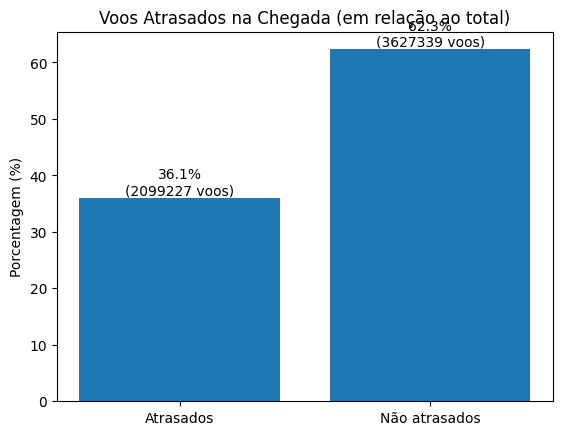

In [7]:
total_voos = len(df)

# Quantidades
qtd_atrasados = np.sum(df["ARRIVAL_DELAY"] > 0)
qtd_no_horario = np.sum(df["ARRIVAL_DELAY"] <= 0)

# Porcentagens (em relação ao total)
percent_atrasados = (qtd_atrasados / total_voos) * 100
percent_no_horario = (qtd_no_horario / total_voos) * 100

# Dados para o gráfico
labels = ["Atrasados", "Não atrasados"]
percentuais = [percent_atrasados, percent_no_horario]
quantidades = [qtd_atrasados, qtd_no_horario]

plt.figure()
bars = plt.bar(labels, percentuais)
plt.ylabel("Porcentagem (%)")
plt.title("Voos Atrasados na Chegada (em relação ao total)")

# Adicionando rótulos (porcentagem + quantidade)
for bar, qtd in zip(bars, quantidades):
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        altura,
        f"{altura:.1f}%\n({qtd} voos)",
        ha="center",
        va="bottom"
    )

plt.show()


#### Atrasos por companhia aérea

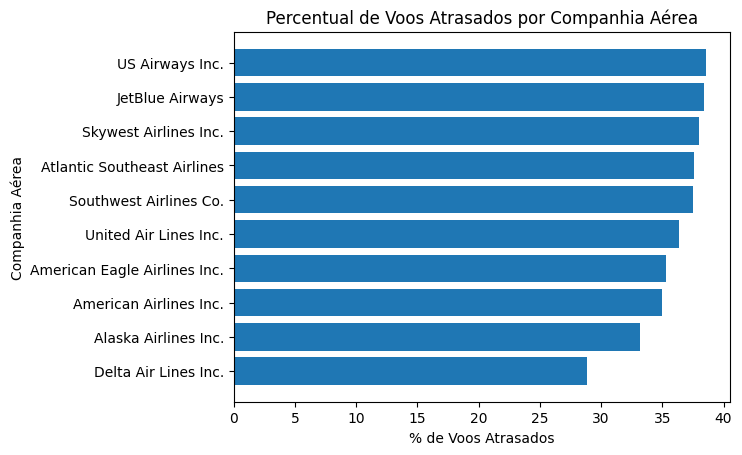

In [8]:
df_merged_airlines = df.merge(
    airlines_df,
    left_on="AIRLINE",
    right_on="IATA_CODE",
    how="left"
)

df_merged_airlines = df_merged_airlines.rename(columns={"AIRLINE_y": "AIRLINE_NAME"})

airline_delay = (
    df_merged_airlines
    .groupby("AIRLINE_NAME")
    .agg(
        total_voos=("FLIGHT_NUMBER", "count"),
        voos_atrasados=("ARRIVAL_DELAY", lambda x: np.sum(x > 0))
    )
)

airline_delay["percent_atrasados"] = (
    airline_delay["voos_atrasados"] / airline_delay["total_voos"] * 100
)

# Filtra companhias com volume relevante
airline_delay = airline_delay[airline_delay["total_voos"] > 10000]

# Ordena
airline_delay = airline_delay.sort_values("percent_atrasados").head(10)

plt.figure()
plt.barh(
    airline_delay.index,
    airline_delay["percent_atrasados"]
)

plt.xlabel("% de Voos Atrasados")
plt.ylabel("Companhia Aérea")
plt.title("Percentual de Voos Atrasados por Companhia Aérea")

plt.show()


#### Percentual de atrasos por aeroporto

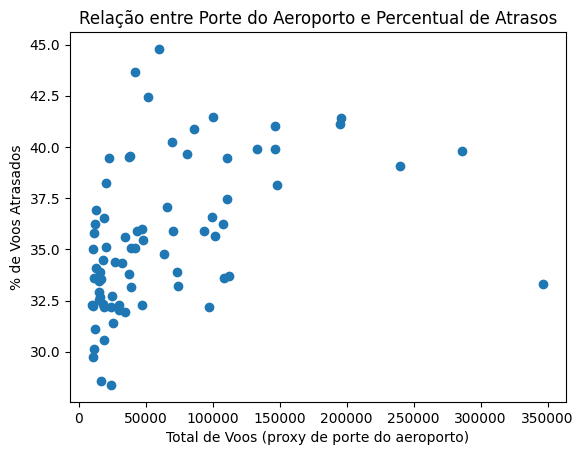

,total_voos,percent_atrasados
total_voos,1.000000,0.431761
percent_atrasados,0.431761,1.000000


In [9]:
df_merged_airports = df.merge(
    airports_df,
    left_on="ORIGIN_AIRPORT",
    right_on="IATA_CODE",
    how="left"
)

df_merged_airports = df_merged_airports.rename(
    columns={"AIRPORT": "AIRPORT_NAME"}
)

airport_delay = (
    df_merged_airports
    .groupby("AIRPORT_NAME")
    .agg(
        total_voos=("FLIGHT_NUMBER", "count"),
        voos_atrasados=("ARRIVAL_DELAY", lambda x: (x > 0).sum())
    )
)

airport_delay["percent_atrasados"] = (
    airport_delay["voos_atrasados"] / airport_delay["total_voos"] * 100
)

airport_delay = airport_delay[airport_delay["total_voos"] > 10000]

airport_delay = (
    airport_delay
    .sort_values("percent_atrasados", ascending=False)
)

plt.figure()

plt.scatter(
    airport_delay["total_voos"],
    airport_delay["percent_atrasados"]
)

plt.xlabel("Total de Voos (proxy de porte do aeroporto)")
plt.ylabel("% de Voos Atrasados")
plt.title("Relação entre Porte do Aeroporto e Percentual de Atrasos")

plt.show()

airport_delay[["total_voos", "percent_atrasados"]].corr()


A análise da correlação entre o total de voos (proxy do porte do aeroporto) e o percentual de voos atrasados resultou em um coeficiente de correlação de aproximadamente 0,43, indicando uma correlação positiva moderada. Esse resultado sugere que aeroportos com maior volume de voos tendem, em média, a apresentar maiores percentuais de atrasos, embora a relação `não seja forte`.


#### Percentual de atrasos durante o ano

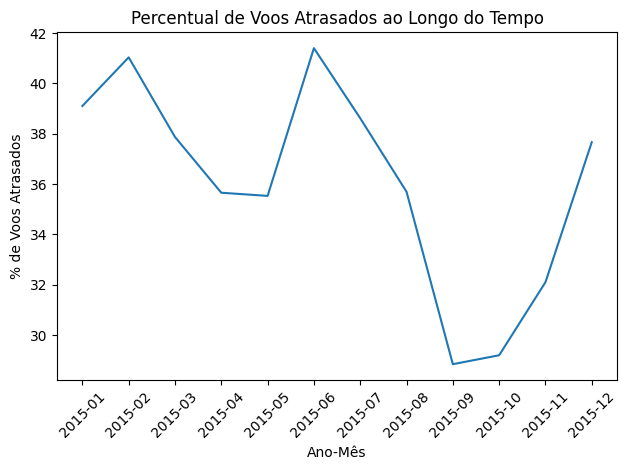

In [10]:
# Agrupamento por ano e mês
delay_time = (
    df
    .groupby(["YEAR", "MONTH"])
    .agg(
        total_voos=("FLIGHT_NUMBER", "count"),
        voos_atrasados=("ARRIVAL_DELAY", lambda x: np.sum(x > 0))
    )
    .reset_index()
)

# Percentual de atraso
delay_time["percent_atrasados"] = (
    delay_time["voos_atrasados"] / delay_time["total_voos"] * 100
)

# Criar eixo temporal contínuo (ótimo para visualização)
delay_time["ANO_MES"] = (
    delay_time["YEAR"].astype(str) + "-" +
    delay_time["MONTH"].astype(str).str.zfill(2)
)

plt.figure()
plt.plot(
    delay_time["ANO_MES"],
    delay_time["percent_atrasados"]
)

plt.xlabel("Ano-Mês")
plt.ylabel("% de Voos Atrasados")
plt.title("Percentual de Voos Atrasados ao Longo do Tempo")

# Melhorar legibilidade do eixo X
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Observam-se aumento nos meses de inverno e durante o verão, períodos que coincidem, respectivamente, com condições climáticas adversas e férias escolares nos Estados Unidos. Meses com menor demanda apresentam percentuais mais baixos de atraso, indicando impacto do volume de passageiros na pontualidade operacional.

#### Correlação com atrasos na chegada com atrasos na saída


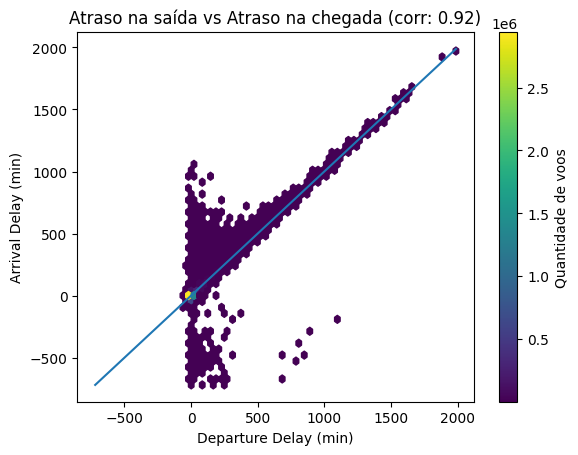

In [11]:
# Seleciona apenas as colunas necessárias e remove null
df_hex = df[["DEPARTURE_DELAY", "ARRIVAL_DELAY"]].dropna()

x = df_hex["DEPARTURE_DELAY"]
y = df_hex["ARRIVAL_DELAY"]

corr = x.corr(y)

plt.figure()
hb = plt.hexbin(
    x,
    y,
    gridsize=50,      
    mincnt=1         
)

plt.xlabel("Departure Delay (min)")
plt.ylabel("Arrival Delay (min)")
plt.title(f"Atraso na saída vs Atraso na chegada (corr: {corr:.2f})")

# Linha de referência y = x (propagação do atraso)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot(
    [min_val, max_val],
    [min_val, max_val]
)

# Barra de cor (densidade)
plt.colorbar(hb, label="Quantidade de voos")

plt.show()

A elevada (0.92) correlação sugere que o atraso na partida é um forte indicador no atraso na chegada. Isso indica um efeito de cascata operacional, no qual atrasos iniciais impactam diretamente etapas subsequentes do voo.

Pontos acima da reta (y > x) indicam que o voo chegou mais atrasado do que saiu. 
Pontos abaixo da reta (y < x) indicam que o voo recuperou parte do atraso durante a operação.

#### Voos Cancelados x Desviados

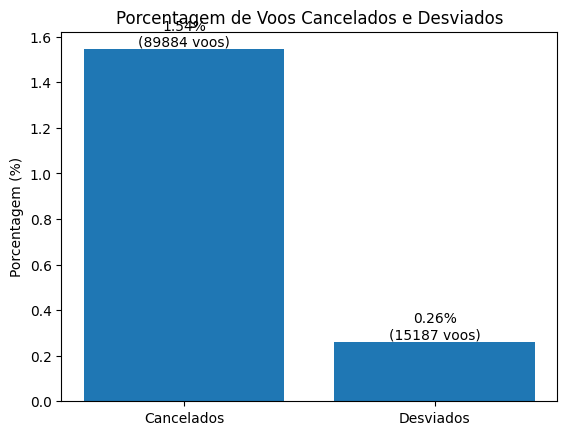

In [12]:
total_voos = len(df)

# Quantidades
qtd_cancelados = np.sum(df["CANCELLED"] == 1)
qtd_desviados = np.sum(df["DIVERTED"] == 1)

# Porcentagens em relação ao total
percent_cancelados = (qtd_cancelados / total_voos) * 100
percent_desviados = (qtd_desviados / total_voos) * 100

plt.figure()
bars = plt.bar(
    ["Cancelados", "Desviados"],
    [percent_cancelados, percent_desviados]
)

plt.ylabel("Porcentagem (%)")
plt.title("Porcentagem de Voos Cancelados e Desviados")

for bar, qtd in zip(bars, [qtd_cancelados, qtd_desviados]):
    altura = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        altura,
        f"{altura:.2f}%\n({qtd} voos)",
        ha="center",
        va="bottom"
    )

plt.show()

A análise mostra que menos de 2% dos voos foram cancelados ou desviados. Isso indica que esses eventos não acontecem frequentemente.


#### Distribuição dos Atrasos de Chegada por Mês

C:\Users\Carol\AppData\Local\Temp\ipykernel_15756\2851431080.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_month, labels=months, showfliers=False)


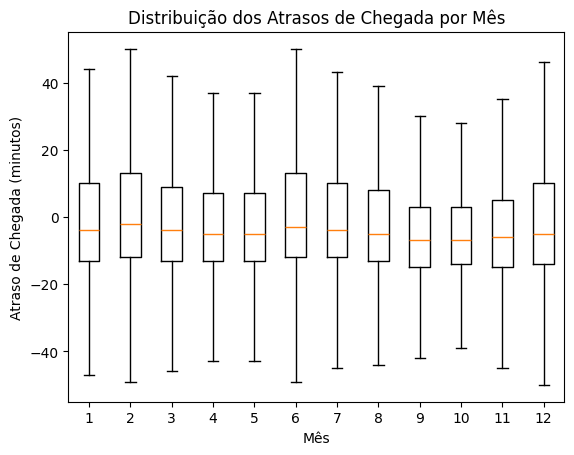

In [13]:
months = sorted(df['MONTH'].unique())
data_by_month = [
    df[df['MONTH'] == m]['ARRIVAL_DELAY'].dropna()
    for m in months
]

plt.figure()
plt.boxplot(data_by_month, labels=months, showfliers=False)
plt.xlabel("Mês")
plt.ylabel("Atraso de Chegada (minutos)")
plt.title("Distribuição dos Atrasos de Chegada por Mês")
plt.show()

Em todos os meses, a mediana dos atrasos permanece abaixo de zero, indicando que mais da metade dos voos chega no horário ou antecipadamente.

Observa-se que os meses de junho, julho e dezembro apresentam maior dispersão e whiskers superiores mais elevados, sugerindo a ocorrência de atrasos durante períodos de alta demanda, como férias escolares e feriados. Esses meses concentram maior variabilidade operacional, o que está alinhado com o aumento do tráfego aéreo e a maior propagação de atrasos em cascata.

Por outro lado, os meses de setembro e outubro apresentam caixas mais compactas e menor amplitude, indicando maior estabilidade operacional e menor incidência de atrasos extremos. Esse comportamento reforça a hipótese de que períodos de menor demanda favorecem um desempenho mais pontual.

#### Medidas de posição

In [14]:
positive_delays = df[df['ARRIVAL_DELAY'] > 0]['ARRIVAL_DELAY']

# Calcular quartis e percentil 90
q1 = positive_delays.quantile(0.25)
q2 = positive_delays.quantile(0.5)
q3 = positive_delays.quantile(0.75)
p90 = positive_delays.quantile(0.9)

print("Medidas de posição dos atrasos na chegada:")
print(f"Q1 (25% dos voos atrasam até): {q1:.2f} minutos")
print(f"Q2 (mediana, 50% dos voos atrasam até): {q2:.2f} minutos")
print(f"Q3 (75% dos voos atrasam até): {q3:.2f} minutos")
print(f"Percentil 90 (90% dos voos têm atraso inferior a): {p90:.2f} minutos")

Medidas de posição dos atrasos na chegada:
Q1 (25% dos voos atrasam até): 6.00 minutos
Q2 (mediana, 50% dos voos atrasam até): 15.00 minutos
Q3 (75% dos voos atrasam até): 39.00 minutos
Percentil 90 (90% dos voos têm atraso inferior a): 87.00 minutos


## Conclusões da Análise Exploratória de Dados (EDA)

*   **Atrasos na Chegada**: Aproximadamente 36% dos voos chegam atrasados, indicando que a maioria dos voos opera pontualmente ou antecipadamente.

*   **Impacto de Companhias Aéreas e Aeroportos**: Existem diferenças significativas no percentual de atrasos entre companhias aéreas e aeroportos. Algumas companhias e aeroportos são consistentemente mais propensos a atrasos do que outros.

*   **Sazonalidade dos Atrasos**: Os atrasos tendem a ser mais frequentes e com maior variabilidade durante os meses de inverno e verão (dezembro, janeiro, fevereiro, junho, julho e agosto). Isso pode ser atribuído a condições climáticas adversas ou ao aumento do volume de tráfego aéreo durante períodos de férias.

*   **Atrasos de Partida e Chegada**: Há uma correlação muito forte (0.92) entre atrasos na partida e atrasos na chegada, sugerindo um efeito cascata. Voos que partem atrasados geralmente chegam atrasados, embora alguns consigam recuperar parte do tempo perdido em trânsito.

*   **Voos Cancelados e Desviados**: Apenas uma pequena porcentagem de voos (menos de 2%) é cancelada ou desviada, indicando que esses eventos são relativamente raros e não são os principais contribuintes para os atrasos.

*   **Mediana de Atrasos**: A mediana dos atrasos de chegada é geralmente negativa, o que reforça que a maior parte dos voos chega no horário ou antes do previsto. No entanto, quando há atrasos positivos, 25% deles são de 6 minutos ou mais, e 90% são de 87 minutos ou menos, destacando a existência de atrasos significativos.

Em resumo, a análise aponta que, embora a maioria dos voos seja pontual, os atrasos são influenciados por fatores como a companhia aérea, o aeroporto de origem, a época do ano e a pontualidade da partida.

## Validação e Avaliação dos Modelos


### 🤖 Modelo Supervisionado – Classificação de Atrasos

#### Limpeza e tratamento dos dados
Para melhorar a qualidade da avaliação, voos cancelados ou desviados foram removidos da base de treinamento, uma vez que não representam atrasos operacionais convencionais.

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

df_model_sup = df.copy()

# Tornar ARRIVAL_DELAY numérica
df_model_sup["DELAYED"] = (df_model_sup["ARRIVAL_DELAY"] > 0).astype(int)

# Remover voos cancelados e desviados
df_model_sup = df_model_sup[
    (df_model_sup["CANCELLED"] == 0) &
    (df_model_sup["DIVERTED"] == 0)
].copy()

# One-Hot Encoding em dados de aeroportos e companhias aéreas
cat_features = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
num_features = [
    "MONTH", "DAY_OF_WEEK",
    "SCHEDULED_DEPARTURE", "SCHEDULED_TIME", "DISTANCE"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features)
    ]
)

# Definir faixa horária
def faixa_horaria(h):
    if h < 600:
        return "madrugada"
    elif h < 1200:
        return "manha"
    elif h < 1800:
        return "tarde"
    else:
        return "noite"

df_model_sup["SCHEDULED_TIME_SLOT"] = df_model_sup["SCHEDULED_DEPARTURE"].apply(faixa_horaria)

# Definir final de semana
df_model_sup["WEEKEND"] = df_model_sup["DAY_OF_WEEK"].isin([6, 7]).astype(int)

df_model_sup.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,DELAYED,SCHEDULED_TIME_SLOT,WEEKEND
0,2015,1,1,4,AS,98,ANC,SEA,5,2354.0,...,1448,4.0,430,408.0,-22.0,0,0,0,madrugada,0
1,2015,1,1,4,AA,2336,LAX,PBI,10,2.0,...,2330,4.0,750,741.0,-9.0,0,0,0,madrugada,0
2,2015,1,1,4,US,840,SFO,CLT,20,18.0,...,2296,11.0,806,811.0,5.0,0,0,1,madrugada,0
3,2015,1,1,4,AA,258,LAX,MIA,20,15.0,...,2342,8.0,805,756.0,-9.0,0,0,0,madrugada,0
4,2015,1,1,4,AS,135,SEA,ANC,25,24.0,...,1448,5.0,320,259.0,-21.0,0,0,0,madrugada,0


#### XGBoost previsão antes da partida

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import xgboost as xgb
import numpy as np

df_improved = df_model_sup.copy()

# Tratar DEPARTURE_DELAY (imputar valores nulos com 0)
df_improved["DEPARTURE_DELAY"] = df_improved["DEPARTURE_DELAY"].fillna(0)

# Features temporais adicionais
df_improved["HOUR"] = df_improved["SCHEDULED_DEPARTURE"].apply(
    lambda x: int(x) // 100 if pd.notna(x) else 0
)
df_improved["IS_WINTER"] = df_improved["MONTH"].isin([12, 1, 2]).astype(int)
df_improved["IS_SUMMER"] = df_improved["MONTH"].isin([6, 7, 8]).astype(int)
df_improved["IS_HOLIDAY_SEASON"] = df_improved["MONTH"].isin([11, 12]).astype(int)

# Feature derivada: velocidade média
df_improved["AVG_SPEED"] = df_improved["DISTANCE"] / (df_improved["SCHEDULED_TIME"] + 1)

# Split treino/teste
df_train_imp, df_test_imp = train_test_split(
    df_improved,
    test_size=0.2,
    random_state=42,
    stratify=df_improved["DELAYED"]
)

# Target encoding suavizado para aeroportos e companhias
def target_encoding_fit_smooth(df, col, target, smoothing=10):
    encoding = df.groupby(col)[target].agg(['mean', 'count'])
    global_mean = df[target].mean()
    encoding['encoded'] = (
        (encoding['count'] * encoding['mean'] + smoothing * global_mean) / 
        (encoding['count'] + smoothing)
    )
    return encoding['encoded'].to_dict(), global_mean

def target_encoding_transform_smooth(series, encoding_dict, global_mean):
    return series.map(encoding_dict).fillna(global_mean)

# Aplicar target encoding
enc_origin, mean_delay = target_encoding_fit_smooth(df_train_imp, "ORIGIN_AIRPORT", "DELAYED")
enc_dest, _ = target_encoding_fit_smooth(df_train_imp, "DESTINATION_AIRPORT", "DELAYED")
enc_airline, _ = target_encoding_fit_smooth(df_train_imp, "AIRLINE", "DELAYED")

df_train_imp["ORIGIN_TE"] = target_encoding_transform_smooth(
    df_train_imp["ORIGIN_AIRPORT"], enc_origin, mean_delay
)
df_train_imp["DEST_TE"] = target_encoding_transform_smooth(
    df_train_imp["DESTINATION_AIRPORT"], enc_dest, mean_delay
)
df_train_imp["AIRLINE_TE"] = target_encoding_transform_smooth(
    df_train_imp["AIRLINE"], enc_airline, mean_delay
)

df_test_imp["ORIGIN_TE"] = target_encoding_transform_smooth(
    df_test_imp["ORIGIN_AIRPORT"], enc_origin, mean_delay
)
df_test_imp["DEST_TE"] = target_encoding_transform_smooth(
    df_test_imp["DESTINATION_AIRPORT"], enc_dest, mean_delay
)
df_test_imp["AIRLINE_TE"] = target_encoding_transform_smooth(
    df_test_imp["AIRLINE"], enc_airline, mean_delay
)

# One-hot encoding para SCHEDULED_TIME_SLOT
df_train_imp = pd.get_dummies(
    df_train_imp,
    columns=["SCHEDULED_TIME_SLOT"],
    drop_first=True
)

df_test_imp = pd.get_dummies(
    df_test_imp,
    columns=["SCHEDULED_TIME_SLOT"],
    drop_first=True
)

# Alinhar colunas
df_train_imp, df_test_imp = df_train_imp.align(df_test_imp, join="left", axis=1, fill_value=0)

# Selecionar features
features_improved = [
    "YEAR", "MONTH", "DAY", "DAY_OF_WEEK", "HOUR",
    "SCHEDULED_DEPARTURE", "DEPARTURE_DELAY", 
    "SCHEDULED_TIME", "DISTANCE", "AVG_SPEED",
    "WEEKEND", "IS_WINTER", "IS_SUMMER", "IS_HOLIDAY_SEASON",
    "ORIGIN_TE", "DEST_TE", "AIRLINE_TE"
]

# Adicionar dummies de SCHEDULED_TIME_SLOT
features_improved += [c for c in df_train_imp.columns if c.startswith("SCHEDULED_TIME_SLOT_")]

X_train_imp = df_train_imp[features_improved]
y_train_imp = df_train_imp["DELAYED"]

X_test_imp = df_test_imp[features_improved]
y_test_imp = df_test_imp["DELAYED"]

# XGBoost com hiperparâmetros otimizados
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    scale_pos_weight=(y_train_imp == 0).sum() / (y_train_imp == 1).sum(),  # Balanceamento
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(
    X_train_imp, y_train_imp,
    eval_set=[(X_test_imp, y_test_imp)],
    verbose=False
)

# Predições
y_pred_xgb = xgb_model.predict(X_test_imp)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_imp)[:, 1]

# Otimizar threshold usando F1-score
thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_xgb >= threshold).astype(int)
    f1 = f1_score(y_test_imp, y_pred_thresh)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_optimized = (y_pred_proba_xgb >= best_threshold).astype(int)

print("=" * 60)
print("MODELO - XGBoost")
print("=" * 60)
print(f"\nThreshold otimizado: {best_threshold:.3f}")
print(f"F1-score no threshold padrão (0.5): {f1_score(y_test_imp, y_pred_xgb):.3f}")
print(f"F1-score no threshold otimizado: {f1_score(y_test_imp, y_pred_optimized):.3f}")

print("\n" + "=" * 60)
print("Matriz de Confusão (Threshold Otimizado):")
print("=" * 60)
print(confusion_matrix(y_test_imp, y_pred_optimized))

print("\n" + "=" * 60)
print("Relatório de Classificação (Threshold Otimizado):")
print("=" * 60)
print(classification_report(y_test_imp, y_pred_optimized))

print("\n" + "=" * 60)
print("AUC-ROC Score:")
print("=" * 60)
print(f"{roc_auc_score(y_test_imp, y_pred_proba_xgb):.4f}")

MODELO - XGBoost

Threshold otimizado: 0.490
F1-score no threshold padrão (0.5): 0.756
F1-score no threshold otimizado: 0.756

Matriz de Confusão (Threshold Otimizado):
[[648302  77121]
 [116724 300655]]

Relatório de Classificação (Threshold Otimizado):
              precision    recall  f1-score   support

           0       0.85      0.89      0.87    725423
           1       0.80      0.72      0.76    417379

    accuracy                           0.83   1142802
   macro avg       0.82      0.81      0.81   1142802
weighted avg       0.83      0.83      0.83   1142802


AUC-ROC Score:
0.8857


##### 📊 Análise
**Por que testar o XGBoost?** <br>
Lida melhor com dados grandes e complexos, captura interações entre variáveis e reduz atrasos não detectados (falsos negativos).

**Análise da Matriz de Confusão:**
- **Verdadeiros Negativos**: 648,302 (89% dos voos pontuais corretamente identificados)
- **Verdadeiros Positivos**: 300,655 (72% dos voos atrasados corretamente identificados)
- **Falsos Positivos**: 77,121 (11% de alarmes falsos)
- **Falsos Negativos**: 116,724 (28% de atrasos não detectados)


**Interpretação dos Resultados:**
O modelo demonstra boa capacidade preditiva, com accuracy de 83% e F1-score de 0.76 para a classe de interesse (voos atrasados). A precisão de 80% indica que, quando o modelo prevê um atraso, há alta confiança de que realmente ocorrerá. O recall de 72% mostra que o modelo identifica corretamente a maioria dos voos que terão atraso, sendo adequado para aplicações práticas onde a detecção precoce de atrasos é crucial.


#### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np

rf_improved = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

rf_improved.fit(X_train_imp, y_train_imp)

# Predições
y_pred_rf_imp = rf_improved.predict(X_test_imp)
y_pred_proba_rf_imp = rf_improved.predict_proba(X_test_imp)[:, 1]

# Otimizar threshold
thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores_rf = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_rf_imp >= threshold).astype(int)
    f1 = f1_score(y_test_imp, y_pred_thresh)
    f1_scores_rf.append(f1)

best_threshold_rf = thresholds[np.argmax(f1_scores_rf)]
y_pred_rf_optimized = (y_pred_proba_rf_imp >= best_threshold_rf).astype(int)

print("=" * 60)
print("RANDOM FOREST")
print("=" * 60)
print(f"\nThreshold otimizado: {best_threshold_rf:.3f}")
print(f"F1-score no threshold padrão (0.5): {f1_score(y_test_imp, y_pred_rf_imp):.3f}")
print(f"F1-score no threshold otimizado: {f1_score(y_test_imp, y_pred_rf_optimized):.3f}")

print("\n" + "=" * 60)
print("Matriz de Confusão (Threshold Otimizado):")
print("=" * 60)
print(confusion_matrix(y_test_imp, y_pred_rf_optimized))

print("\n" + "=" * 60)
print("Relatório de Classificação (Threshold Otimizado):")
print("=" * 60)
print(classification_report(y_test_imp, y_pred_rf_optimized))

print("\n" + "=" * 60)
print("AUC-ROC Score:")
print("=" * 60)
print(f"{roc_auc_score(y_test_imp, y_pred_proba_rf_imp):.4f}")


RANDOM FOREST

Threshold otimizado: 0.460
F1-score no threshold padrão (0.5): 0.746
F1-score no threshold otimizado: 0.748

Matriz de Confusão (Threshold Otimizado):
[[645574  79849]
 [120417 296962]]

Relatório de Classificação (Threshold Otimizado):
              precision    recall  f1-score   support

           0       0.84      0.89      0.87    725423
           1       0.79      0.71      0.75    417379

    accuracy                           0.82   1142802
   macro avg       0.82      0.80      0.81   1142802
weighted avg       0.82      0.82      0.82   1142802


AUC-ROC Score:
0.8808


📊 Análise

Análise da Matriz de Confusão:

Verdadeiros Negativos: 645.574 (89% dos voos sem atraso corretamente identificados)

Verdadeiros Positivos: 296.962 (71% dos voos atrasados corretamente identificados)

Falsos Positivos: 79.849 (11% de alarmes falsos)

Falsos Negativos: 120.417 (29% dos atrasos não detectados)

Interpretação dos Resultados:
O modelo apresenta bom desempenho preditivo, com accuracy de 82%, AUC-ROC de 0.88 e F1-score de 0.75 para a classe de interesse (voos atrasados). A precisão de 79% indica que, quando o modelo prevê um atraso, há elevada probabilidade de que ele realmente ocorra. O recall de 71% mostra que o modelo consegue identificar a maioria dos voos que irão atrasar, embora ainda deixe escapar parte dos atrasos reais.

#### Análise final
Os dois modelos têm desempenho muito parecido. O XGBoost é ligeiramente melhor, detectando um pouco mais de voos atrasados e perdendo menos atrasos, sem aumentar os alarmes falsos.
Caso o custo de processamento seja uma variável importante na escolha do modelo, o Random Forest é a melhor escolha, porém, se o foco for melhor desempenho preditivo e o custo computacional não for um problema, XGBoost é o ideal.

### 🤖 Modelo não supervisionado
Foi aplicada uma abordagem de aprendizado não supervisionado utilizando o algoritmo K-Means para agrupar voos com características semelhantes, considerando horário programado, duração, distância e se o voo ocorre em fim de semana. A análise dos clusters revelou diferenças significativas na taxa de atraso entre os grupos, indicando que determinados perfis de voo apresentam maior propensão a atrasos.

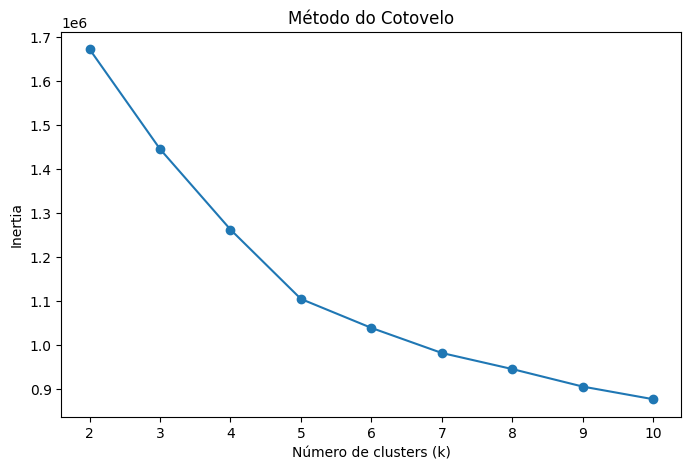

In [18]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

features = [
    "MONTH",
    "DAY_OF_WEEK",
    "SCHEDULED_DEPARTURE",
    "SCHEDULED_TIME",
    "DISTANCE",
    "WEEKEND",
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "SCHEDULED_TIME_SLOT"
]


df_model = df_model_sup[features].copy()

categorical_cols = [
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "SCHEDULED_TIME_SLOT"
]

le = LabelEncoder()

for col in categorical_cols:
    df_model[col] = le.fit_transform(df_model[col].astype(str))

df_model["SCHEDULED_HOUR"] = df_model["SCHEDULED_DEPARTURE"] // 100
df_model.drop(columns=["SCHEDULED_DEPARTURE"], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

sample_idx = np.random.choice(len(X_scaled), size=200_000, replace=False)
X_sample = X_scaled[sample_idx]

inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_sample)
    inertia.append(kmeans.inertia_)

# Gráfico cotovelo
plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inertia")
plt.title("Método do Cotovelo")
plt.show()

A partir da análise do método do cotovelo, observa-se um redução acentudada na inércia onde k = 4. Portanto, iremos considerar 4 o nosso número de clusters.

#### Kmeans

In [19]:
k = 4

kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init=10
)

df_model["CLUSTER"] = kmeans.fit_predict(X_scaled)

sil_score = silhouette_score(X_sample, kmeans.predict(X_sample))
print(f"Silhouette Score: {sil_score:.3f}")

df_model_sup["CLUSTER"] = df_model["CLUSTER"]
cluster_delay = (
    df_model_sup.groupby("CLUSTER")["DEPARTURE_DELAY"]
    .agg(["mean", "median", "count"])
)

print(cluster_delay)

Silhouette Score: 0.196
              mean  median    count
CLUSTER                            
0         8.439612    -2.0  1340454
1         4.663462    -3.0  1529568
2        12.694962    -1.0  2119473
3        10.708125     0.0   724513


A análise dos clusters revelou que: O cluster 1 apresentou o melhor desempenho operacional, com menor média e mediana negativa de atraso, indicando voos predominantemente pontuais. O cluster 2 concentrou os maiores atrasos médios. O Silhouette Score de 0,196 indica uma separação moderada entre os grupos.

#### Visualização dos clusters - PCA

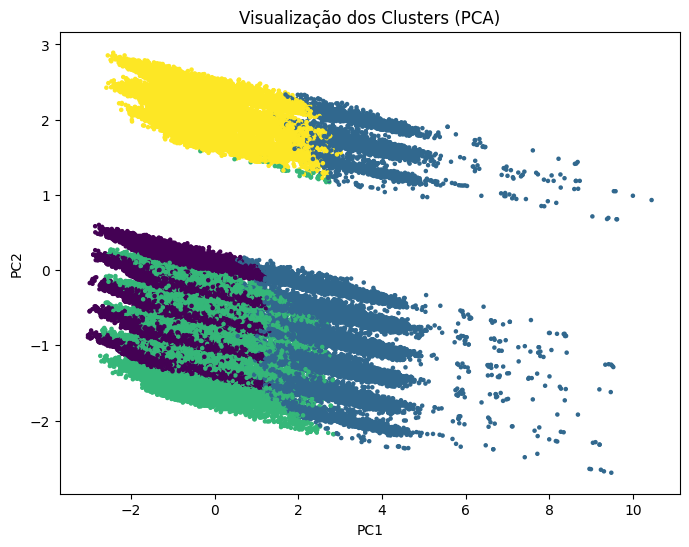

In [20]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample)

kmeans_sample = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters_sample = kmeans_sample.fit_predict(X_sample)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters_sample,
    s=5
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Visualização dos Clusters (PCA)")
plt.show()

O PC1 representa a direção de maior variação entre os voos, enquanto o PC2 captura a segunda maior variação independente da primeira. A visualização dos clusters no espaço PCA indica que os grupos identificados pelo KMeans apresentam estrutura consistente, validando a segmentação dos voos em perfis distintos.

📊 Análise

A aplicação de técnicas de aprendizado não supervisionado permitiu identificar padrões relevantes nos dados de voos, segmentando-os em grupos com características operacionais semelhantes. Os clusters apresentaram diferenças significativas nos níveis médios de atraso, indicando que fatores como horário, distância e rota influenciam o desempenho dos voos. A análise via PCA confirmou a consistência da clusterização.